In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ollama  # LLaMA model API
import re
from tqdm import tqdm  # For progress bars
from concurrent.futures import ThreadPoolExecutor, as_completed  # For parallel processing
from gnews import GNews  # Import the GNews package
from pytz import UTC

In [3]:
df = pd.read_csv('all_ECB_speeches.csv', sep='|')
df

,date,speakers,title,subtitle,contents
0,2025-01-27,Christine Lagarde,Central bank independence in an era of volatility,"Lamfalussy Lecture by Christine Lagarde, Presi...",SPEECH Central bank independence in an era ...
1,2025-01-17,Piero Cipollone,The role of central bank money in digital paym...,"Slides by Piero Cipollone, Member of the Execu...",NaN
2,2025-01-15,Luis de Guindos,The economic outlook and monetary policy in th...,"Speech by Luis de Guindos, Vice-President of t...",SPEECH The economic outlook and monetary po...
3,2025-01-14,Philip R. Lane,The euro area outlook and monetary policy,"Slides by Philip R. Lane, Member of the Execut...",NaN
4,2025-01-03,Philip R. Lane,Navigating a fragmenting global trading system...,"Slides by Philip R. Lane, Member of the Execut...",NaN
...,...,...,...,...,...
2865,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2866,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2867,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2868,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


In [5]:
print(df['contents'][2])

  SPEECH  The economic outlook and monetary policy in the euro area   Speech by Luis de Guindos, Vice-President of the ECB, at the 15th edition of Spain Investors Day Madrid, 15 January 2025 It is a pleasure to speak here again this year.[1] In my remarks last year, I expanded on monetary policy in the face of high inflation risks. The outlook was then still being shaped by the easing of pandemic-related supply constraints and by the energy price shock. Inflation had fallen rapidly from its peak in autumn 2022, but we needed to keep monetary policy sufficiently restrictive to ensure a timely and sustainable return of inflation to our 2% target. Today, the euro area is in a very different place. Having cut interest rates four times since last June, by a total of 100 basis points, we have made substantial progress in bringing inflation back to target. At the same time, the balance of macroeconomic risks has shifted from concerns about high inflation to concerns about low growth. The outl

# Sentense to Paragraphs
- Source: https://github.com/poloniki/quint/blob/master/notebooks/Chunking%20text%20into%20paragraphs.ipynb

### Import Libraries

In [9]:
# First let import the most necessary libs
import pandas as pd
import numpy as np
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema
import math
import pysbd

### Loading the text

In [13]:
seg = pysbd.Segmenter(language="en", clean=False)

# We need to split whole text into sentences first.
sentences = seg.segment(df['contents'][2])

print('Loaded Text String to Sentence list')

Loaded Text String to Sentence list


### Load Emmbedding Model

In [14]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')

03/06/2025 11:21:29 AM - Use pytorch device_name: cuda
03/06/2025 11:21:29 AM - Load pretrained SentenceTransformer: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Embedding the Sentencess

In [15]:
# Embed sentences
embeddings = model.encode(sentences)
print(embeddings.shape)

# Normalize the embeddings
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings = embeddings / norms

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


### Computing Cosine simmilarity for generating a paragraph from the sentnces.

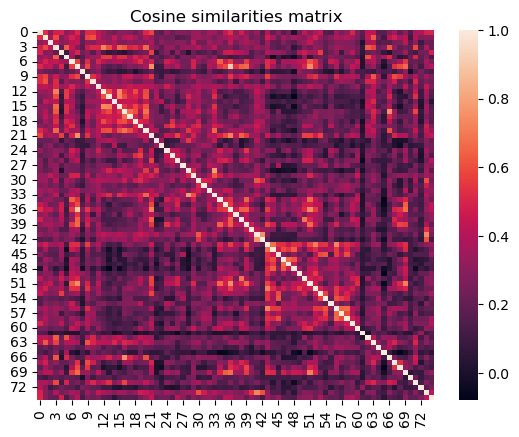

In [16]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix');

### Find Splitting Points

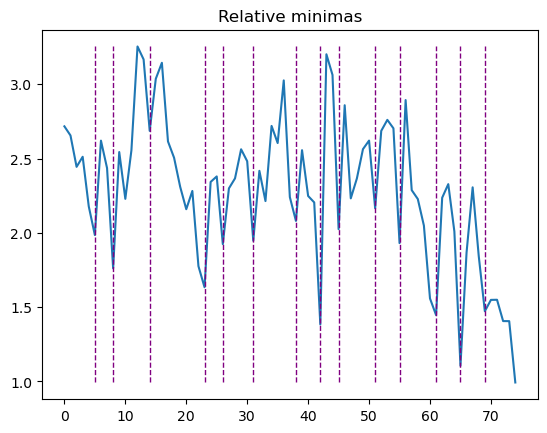

In [28]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities:np.array, p_size=5)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid)
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=10)

# Let's create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

### Splitting the text in paragraphs

In [29]:
# Create empty string
split_points = [each for each in minmimas[0]]
text = ''
for num,each in enumerate(sentences):
    if num in split_points:
        text+=f'\n\n {each} '
    else:
        text+=f'{each} '
print(text)

SPEECH  The economic outlook and monetary policy in the euro area   Speech by Luis de Guindos, Vice-President of the ECB, at the 15th edition of Spain Investors Day Madrid, 15 January 2025 It is a pleasure to speak here again this year.[1]  In my remarks last year, I expanded on monetary policy in the face of high inflation risks.  The outlook was then still being shaped by the easing of pandemic-related supply constraints and by the energy price shock.  Inflation had fallen rapidly from its peak in autumn 2022, but we needed to keep monetary policy sufficiently restrictive to ensure a timely and sustainable return of inflation to our 2% target.  Today, the euro area is in a very different place.  

 Having cut interest rates four times since last June, by a total of 100 basis points, we have made substantial progress in bringing inflation back to target.  At the same time, the balance of macroeconomic risks has shifted from concerns about high inflation to concerns about low growth.  

In [45]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities:np.array, p_size=5)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid)
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

seg = pysbd.Segmenter(language="en", clean=False)
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')
def text2para(text):
    if isinstance(text, str):
        sentences = seg.segment(text)
        if len(sentences)<=10:
            return text
        
        # Embed sentences
        embeddings = model.encode(sentences)
        print(embeddings.shape)
        
        # Normalize the embeddings
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        embeddings = embeddings / norms
        
        # Create similarities matrix
        similarities = cosine_similarity(embeddings)
        
        # Let's apply our function. For long sentences i reccomend to use 10 or more sentences
        activated_similarities = activate_similarities(similarities, p_size=10)
        
        ### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
        minmimas = argrelextrema(activated_similarities, np.less, order=3) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
        
        # Create empty string
        split_points = [each for each in minmimas[0]]
        text = ''
        for num,each in enumerate(sentences):
            if num in split_points:
                text+=f'\n\n {each} '
            else:
                text+=f'{each} '
        return(text)
    else:
        return(text)

03/06/2025 01:23:34 PM - Use pytorch device_name: cuda
03/06/2025 01:23:34 PM - Load pretrained SentenceTransformer: all-mpnet-base-v2


In [46]:
df['contents_para'] = df['contents'].apply(text2para)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

(551, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(300, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(23, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(242, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(243, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(213, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

(461, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(357, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(266, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

(513, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(220, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(286, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(160, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(316, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(216, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(329, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(310, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(215, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(160, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(336, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(232, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(221, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(302, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(201, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(292, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(262, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(217, 768)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

(493, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(236, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(272, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(302, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(392, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(180, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(238, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(186, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(176, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(253, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(312, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(304, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(221, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(25, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(242, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(23, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(17, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(209, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(234, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(186, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(168, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(237, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(208, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(286, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(281, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(12, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(250, 768)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

(425, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(223, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(213, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(208, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(220, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(315, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(23, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(224, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(217, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(356, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(30, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(352, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(375, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(264, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(209, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(357, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(260, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(225, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(356, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(185, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(216, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(222, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(216, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(186, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(247, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(280, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(217, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(254, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(249, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(217, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(208, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(218, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(36, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(222, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

(708, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(242, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(25, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(32, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(336, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(231, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(215, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(222, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(377, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(375, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(11, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(231, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(239, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(259, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(21, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(252, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(26, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(223, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(254, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(15, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(235, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(290, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

(705, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(354, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(189, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(30, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(220, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(272, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(233, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(289, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(189, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(17, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(203, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(267, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(221, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(213, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(242, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(262, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(220, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(21, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(180, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(252, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(201, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(22, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(176, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(36, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(247, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(245, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(14, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(185, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(190, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(252, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(22, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(198, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(203, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(32, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(391, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(25, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(235, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(248, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(180, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(244, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(236, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(230, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(218, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(358, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(267, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(17, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(278, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(305, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(19, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(198, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(18, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(277, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(268, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(239, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(243, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(236, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(247, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(295, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(286, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(328, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(242, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(235, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(222, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(176, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(364, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(168, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(245, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(201, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(26, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(17, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(311, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(21, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(354, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(201, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(219, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(240, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(224, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(234, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(176, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(259, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(213, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(292, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(217, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(192, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(280, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(224, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(248, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(259, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(338, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(23, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(265, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(36, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(302, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(223, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(190, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(271, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(328, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(168, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(243, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(264, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

(428, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(20, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(21, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(250, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(176, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(269, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(245, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(32, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(190, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(335, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(344, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(250, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(231, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(168, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(315, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(185, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(281, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(225, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(225, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(255, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(272, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(268, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(262, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(243, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(229, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(224, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(198, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(27, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(31, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(314, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(30, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(232, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(260, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(209, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(290, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(209, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(191, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(238, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(32, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(299, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(190, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(324, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(285, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(29, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(186, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(293, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(281, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(255, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(395, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(244, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(291, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(300, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(267, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(207, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(312, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(144, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(224, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(268, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(216, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(198, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(337, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(218, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(244, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(179, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(252, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(204, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(206, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(195, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(218, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(215, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(18, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(189, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(254, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(160, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(239, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(53, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(300, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(281, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(37, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(264, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(236, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(57, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(184, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(19, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(205, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(115, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(40, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(36, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(304, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(248, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(215, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(180, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(132, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(185, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(248, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(140, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(388, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(325, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(35, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(241, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(39, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(128, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(163, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(279, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(278, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(281, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(250, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(232, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(45, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(189, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(271, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(327, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(158, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(99, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(54, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(34, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(188, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(67, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(44, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(349, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(181, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(97, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(142, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(135, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(159, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(167, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(26, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(136, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(233, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(225, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

(451, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(292, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(51, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(177, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(73, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(78, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(169, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(262, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(127, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(66, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(309, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(43, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(389, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(309, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

(509, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(141, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(42, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(81, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(143, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

(602, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(208, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(28, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(33, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(200, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(193, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(63, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

(546, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(49, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(166, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(214, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

(573, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(180, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(328, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(160, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

(327, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(56, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(47, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(100, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(93, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(210, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

(470, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(87, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(110, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(172, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(41, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(79, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(147, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(290, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(209, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(258, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(139, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(317, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

(705, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(227, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(211, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(263, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(185, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

(784, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(74, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(138, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(121, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(241, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(251, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(152, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(118, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(271, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(202, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(190, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(151, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(150, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(156, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(170, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(106, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

(432, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(120, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

(408, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(145, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(61, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(194, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(80, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(105, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(196, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(133, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(182, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(165, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(126, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(357, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(95, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(216, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(353, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(162, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(123, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(68, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(129, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(173, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(71, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(19, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(226, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(124, 768)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

(432, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(113, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(137, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(60, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(309, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(76, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

(364, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(171, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(155, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(199, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(246, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(201, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(103, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(62, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(149, 768)


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

(634, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(86, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(276, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(197, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(77, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(101, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(52, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(153, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(98, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(90, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(186, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(111, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(319, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(157, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(175, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(187, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(263, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(89, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(174, 768)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

(484, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(148, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(21, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(178, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(122, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(146, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(116, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(183, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(108, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(245, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(161, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(160, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(234, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(65, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(58, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(88, 768)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

(164, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(220, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(70, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(38, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(83, 768)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(218, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(82, 768)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(12, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(75, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(59, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(48, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(228, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(125, 768)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

(254, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(112, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(92, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(117, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(55, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(102, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(109, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(104, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(134, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(107, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(114, 768)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

(119, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(69, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(91, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(131, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(64, 768)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(46, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(72, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(94, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(96, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(130, 768)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 768)


In [47]:
df

,date,speakers,title,subtitle,contents,contents_para
0,2025-01-27,Christine Lagarde,Central bank independence in an era of volatility,"Lamfalussy Lecture by Christine Lagarde, Presi...",SPEECH Central bank independence in an era ...,SPEECH Central bank independence in an era of...
1,2025-01-17,Piero Cipollone,The role of central bank money in digital paym...,"Slides by Piero Cipollone, Member of the Execu...",NaN,NaN
2,2025-01-15,Luis de Guindos,The economic outlook and monetary policy in th...,"Speech by Luis de Guindos, Vice-President of t...",SPEECH The economic outlook and monetary po...,SPEECH The economic outlook and monetary poli...
3,2025-01-14,Philip R. Lane,The euro area outlook and monetary policy,"Slides by Philip R. Lane, Member of the Execut...",NaN,NaN
4,2025-01-03,Philip R. Lane,Navigating a fragmenting global trading system...,"Slides by Philip R. Lane, Member of the Execut...",NaN,NaN
...,...,...,...,...,...,...
2865,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,The European Central Bank: independent and acc...
2866,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,The operation of monetary policy in stage thre...
2867,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,Convergence and the role of the European Centr...
2868,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,Securing the benefits of EMU Address by Alex...


In [48]:
df.to_csv("all_ECB_speeches_para.csv", index=False)